In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from pandas import ExcelWriter

from sklearn import preprocessing

import math, random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score, accuracy_score
import os
from keras import regularizers
from numpy import array, hstack, vstack



# os.chdir("C:/Users/VIP13/Статья 2/Котировки 6")
os.chdir("your directory")

In [3]:
from sklearn.metrics import f1_score, accuracy_score

def accuracy(orig, prog):

    orig_1=orig[:-1]
    orig_2=[]
    for i in range(1, len(orig)):
        orig_2.append(orig[i])


    prog_1=prog[:-1]
    prog_2=[]
    for i in range(1, len(prog)):
        prog_2.append(prog[i])

    differ_fr=pd.DataFrame()
    differ_fr['orig_bin']=orig_2-orig_1
    differ_fr['prog_bin']=prog_2-prog_1

    differ_fr[differ_fr < 0] = 0
    differ_fr[differ_fr > 0] = 1
    accur=accuracy_score(differ_fr['orig_bin'], differ_fr['prog_bin'])
#     print(accur)
    return accur

# TCM

In [4]:
from numpy.linalg import solve


def my_method_1(index_list, len_wind, step_smooth):
    prognoz=[]

    iteratation_5=int((len(index_list)-len_wind)/step_smooth)+1


    itog_prog=[]
    for i in range(0,iteratation_5):
        train=index_list[0+step_smooth*i:len_wind+step_smooth*i] 



        t=len(train)

        y1=[]
        y2=[]
        y3=[]
        y4=[]

        y_ist=[]
        y_ist.append(train[0])

        y_prog=[]
        y_prog.append(train[0])
        y_prog.append(train[1])


        y1.append(train[0])#
        y2.append(0)#Изменение
        y3.append(train[0]-y_prog[0])# ошибка прошлого прогноза
        y4.append(0)# ошибка изменения


        for i in range(1,t-1):

            y_ist.append(train[i+1])
            y1.append(train[i])
            y2.append(train[i]-train[i-1])#izmeneniya
            y3.append(train[i]-y_prog[i])#err
            y4.append(train[i]-train[i-1]-y_prog[i]+y_prog[i-1])#err izmeneniya

            y=np.array([y1,
                y2,
                y3,
                y4])

            m_y=np.dot(y,y.T)

            if i<3:
                m_y=m_y+np.diag(np.full(4,1))
            else:
                m_y=m_y  

        #     y_t=y1[-1]


            mb_y=np.dot(y,y_ist)

            resh=solve(m_y, mb_y)

            y_prog.append(resh[0]*y1[-1]+resh[1]*y2[-1]+resh[2]*y3[-1]+resh[3]*y4[-1])

        #     print(i)

        i=t-1
        y_ist.append(train[t-1])
        y1.append(train[i])
        y2.append(train[i]-train[i-1])#izmeneniya
        y3.append(train[i]-y_prog[i])#err
        y4.append(train[i]-train[i-1]-y_prog[i]+y_prog[i-1])#err izmeneniya

        y=np.array([y1,
                y2,
                y3,
                y4])

        m_y=np.dot(y,y.T)

        if i<3:
            m_y=m_y+np.diag(np.full(4,1))
        else:
            m_y=m_y  

        #     y_t=y1[-1]


        mb_y=np.dot(y,y_ist)

        resh=solve(m_y, mb_y)

        y_prog.append(resh[0]*y1[-1]+resh[1]*y2[-1]+resh[2]*y3[-1]+resh[3]*y4[-1])
        prognoz.append(y_prog[-1])
    return prognoz


0.2820729274477782
0.6449704142011834


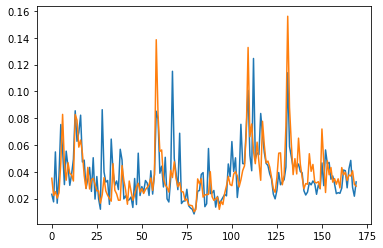

In [147]:
progn=my_method_1(index_list, len_wind, step_smooth)
frame_3=pd.read_csv('all_snp_btc_rv_rr.csv', delimiter=';')
frame=frame_3.iloc[:,1:].copy() #на входе подаются квадраты волатильностей, поэтому сначала из них берем корни, а потом логарифмируем
frame=frame.loc[:, [c for c in frame.columns if (frame[c]>0).all()]]
frame=np.log(np.sqrt(frame))
ind=[i for i in range(0,len(frame))]
frame.index=ind
index_list=np.array(frame['rv_shk_btc'])

progn=my_method_1(index_list, len_wind, step_smooth)

orig=[]
for i in range(0,iteratation_5):
    trainss=index_list[0+step_smooth*i:len_wind+1+step_smooth*i] 
    orig.append(trainss[-1])
    
plt.plot(np.exp(orig))
plt.plot(np.exp(progn))
print((abs(np.exp(orig)-np.exp(progn))/np.exp(orig)).mean())
print(accuracy(np.exp(orig),np.exp(progn)))

# CTCM

In [5]:
def my_method_1_correct(index_list, len_wind, step_smooth, persentile):
    prognoz=[]

    iteratation_5=int((len(index_list)-len_wind)/step_smooth)+1

    prognoz_correct=[]
    itog_prog=[]
    for i in range(0,iteratation_5):
        train=index_list[0+step_smooth*i:len_wind+step_smooth*i] 



        t=len(train)

        y1=[]
        y2=[]
        y3=[]
        y4=[]

        y_ist=[]
        y_ist.append(train[0])

        y_prog=[]
        y_prog.append(train[0])
        y_prog.append(train[1])


        y1.append(train[0])#
        y2.append(0)#Изменение
        y3.append(train[0]-y_prog[0])#
        y4.append(0)# 

        tmp_prog=[]
        for i in range(1,t-1):

            y_ist.append(train[i+1])
            y1.append(train[i])
            y2.append(train[i]-train[i-1])#izmeneniya
            y3.append(train[i]-y_prog[i])#err
            y4.append(train[i]-train[i-1]-y_prog[i]+y_prog[i-1])#err izmeneniya

            y=np.array([y1,
                y2,
                y3,
                y4])

            m_y=np.dot(y,y.T)

            if i<3:
                m_y=m_y+np.diag(np.full(4,1))
            else:
                m_y=m_y  

        #     y_t=y1[-1]


            mb_y=np.dot(y,y_ist)

            resh=solve(m_y, mb_y)

            y_prog.append(resh[0]*y1[-1]+resh[1]*y2[-1]+resh[2]*y3[-1]+resh[3]*y4[-1])
            tmp_prog.append(resh[0]*y1[-1]+resh[1]*y2[-1]+resh[2]*y3[-1]+resh[3]*y4[-1])


        tmp_mape_vec=((np.array(tmp_prog)-np.array(train[-len(tmp_prog)-1:-1]))/np.array(train[-len(tmp_prog)-1:-1]))
        tmp_mape=tmp_mape_vec.mean()
        i=t-1
        y_ist.append(train[t-1])
        y1.append(train[i])
        y2.append(train[i]-train[i-1])#izmeneniya
        y3.append(train[i]-y_prog[i])#err
        y4.append(train[i]-train[i-1]-y_prog[i]+y_prog[i-1])#err izmeneniya

        y=np.array([y1,
                y2,
                y3,
                y4])

        m_y=np.dot(y,y.T)

        if i<3:
            m_y=m_y+np.diag(np.full(4,1))
        else:
            m_y=m_y  

        #     y_t=y1[-1]


        mb_y=np.dot(y,y_ist)

        resh=solve(m_y, mb_y)

        y_prog.append(resh[0]*y1[-1]+resh[1]*y2[-1]+resh[2]*y3[-1]+resh[3]*y4[-1])


        prognoz.append(y_prog[-1])
        prognoz_correct.append(y_prog[-1]*(1+np.percentile(tmp_mape_vec, persentile)))#
    return prognoz_correct

0.2820729274477782
0.6449704142011834
0.25332205210234304
0.6331360946745562


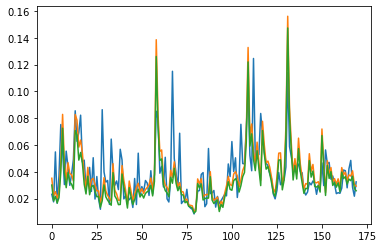

In [15]:
# progn=my_method_1(index_list, len_wind, step_smooth)
frame_3=pd.read_csv('all_snp_btc_rv_rr.csv', delimiter=';')
frame=frame_3.iloc[:,1:].copy()
frame=frame.loc[:, [c for c in frame.columns if (frame[c]>0).all()]]
frame=np.log(np.sqrt(frame))
ind=[i for i in range(0,len(frame))]
frame.index=ind
index_list=np.array(frame['rv_shk_btc'])

len_wind=399
step_smooth=5
persentile=80
iteratation_5=int((len(index_list)-len_wind)/step_smooth)+1

orig=[]
for i in range(0,iteratation_5):
    trainss=index_list[0+step_smooth*i:len_wind+1+step_smooth*i] 
    orig.append(trainss[-1])

    
progn=my_method_1(index_list, len_wind, step_smooth)
progn_correct=my_method_1_correct(index_list, len_wind, step_smooth, persentile)
    

plt.plot(np.exp(orig))
plt.plot(np.exp(progn))
plt.plot(np.exp(progn_correct))

print((abs(np.exp(orig)-np.exp(progn))/np.exp(orig)).mean())
print(accuracy(np.exp(orig),np.exp(progn)))

print((abs(np.exp(orig)-np.exp(progn_correct))/np.exp(orig)).mean())
print(accuracy(np.exp(orig),np.exp(progn_correct)))

# snp
# 0.3370747644005228
# 0.5739644970414202

# 0.3205467360210444
# 0.5739644970414202

# btc
# 0.2820729274477782
# 0.6449704142011834

# 0.25332205210234304
# 0.6331360946745562

In [16]:
itog_df=pd.DataFrame()
itog_df['orig']=np.exp(orig)
itog_df['progn_correct']=np.exp(progn_correct)
itog_df.to_csv('MTK_btc.csv')